In [1]:
import jpype

jpype.startJVM(jpype.getDefaultJVMPath())

In [68]:
import pickle as pkl
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq
from scipy.signal import chirp as chirpsig
from scipy.signal import find_peaks as find_peaks
from scipy.signal import get_window
import matplotlib as mpl

In [70]:
dir = '../results/2022-11-22T11:28:50'
files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
cal_sample_rate = 1/cal_time_per_sample


# MD 9044

- Slow Extraction performed at PS to East, using both Qmeter/BBQ-driven dampers, and an AFG
- Scans done for many parameters over different ranges, including:
  - Interval (time between successive chirps) scans from 1 to 50ms
  - Chirp Frequency Range (changing from above and below)
  - Gain scans, mostly around 0.1 gain
  - Turn (number of machine turns the chirp takes place over) scans in powers of 2

## Data Recorded
- OASIS scope connected to readout of damper plates - showing the voltage applied
  - For some scans, the scope was set to look at a single chirp - usually lasting ~0.6ms (256 turns in the machine)
  - For other scans, the scope was set to look at the whole excitation - usually lasting ~500ms (time before dump)
- Calorimeters (**BXSCAL**) located at East extraction
- Scintillators (**BXSCINT**) located at East extraction
- Beam Loss Monitors
- Initial settings for parameter scan

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(11, 4), sharex='col')

### Ideal signal ###
# set start and stop freq
start = 397*1e3*0.3
stop = 397*1e3*0.35
dur = 1e-3/397 * 256

# Generate arrays
timearr = np.linspace(0, dur, 100000)
amparr = chirpsig(timearr, start, timearr[-1], stop)
ideal_time_per_sample = timearr[-1] / len(timearr)
ideal_sample_rate = 1/ideal_time_per_sample

# Perform FFT
w = get_window(('tukey', 0.001), len(amparr))
scp_df = rfft(amparr*w)
scp_xf = rfftfreq(len(timearr), ideal_time_per_sample)

# Plot
ax[0, 0].set_title("Time domain")
ax[0, 0].plot(timearr, amparr*w, 'xkcd:green')
ax[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

ax[0, 1].set_title("Frequency domain")
ax[0, 1].plot(scp_xf, np.abs(scp_df), 'xkcd:green', label="Ideal chirp signal FFT")
ax[0, 1].set_xlim(0.1e6, 0.2e6)
fmt = lambda x, pos: '{:.0f}'.format(x*1e-3, pos)
ax[0, 1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

### Scope signal ###
scp_time = np.array(scope0[1]['data']['time']) * 1e-9 # convert to seconds
scp_timeRebase = scp_time - scp_time[0]
scp_data = np.array(scope0[1]['data']['value'])

w = get_window(('tukey', 0.001), len(scp_data[1100:65500]))
windowed_data = scp_data[1100:65500] * w / 10000
windowed_time = scp_timeRebase[1100:65500] - scp_timeRebase[1100]

scope_time_per_sample = windowed_time[-1] / len(windowed_time)
scope_sample_rate = 1/scope_time_per_sample

ax[1, 0].plot(windowed_time, windowed_data, 'xkcd:blue')

data_amp = rfft(windowed_data)
data_freq = rfftfreq(len(windowed_time), scope_time_per_sample)

ax[1, 1].plot(data_freq, np.abs(data_amp), 'xkcd:blue', label="Measured chirp signal FFT")


# Extras
ax[0, 1].axvline(start, color='r', linestyle='--')
ax[0, 1].axvline(stop, color='r', linestyle='--')
ax[1, 1].axvline(start, color='r', linestyle='--')
ax[1, 1].axvline(stop, color='r', linestyle='--')

ax[1, 1].set_xlabel("Frequency (kHz)")
ax[1, 0].set_xlabel("Seconds")

ax[0, 0].set_ylabel("Ideal Signal")
ax[1, 0].set_ylabel("Scope Signal")

ax[0, 1].legend()
ax[1, 1].legend()

plt.suptitle(f"Single Ideal chirp vs observed chirp \n from {start*1e-6} MHz to {stop*1e-6} MHz (.3 to .35 Q) in {dur*1e6:.1f} $\mu$s seconds", y=1.07)


Text(0.5, 1.07, 'Single Ideal chirp vs observed chirp \n from 0.1191 MHz to 0.13895 MHz (.3 to .35 Q) in 644.8 $\\mu$s seconds')

- Simulations of single chirps show good agreement with measured data

Text(0.5, 0.98, 'A single chirp from the OASIS scope of a whole-extraction signal')

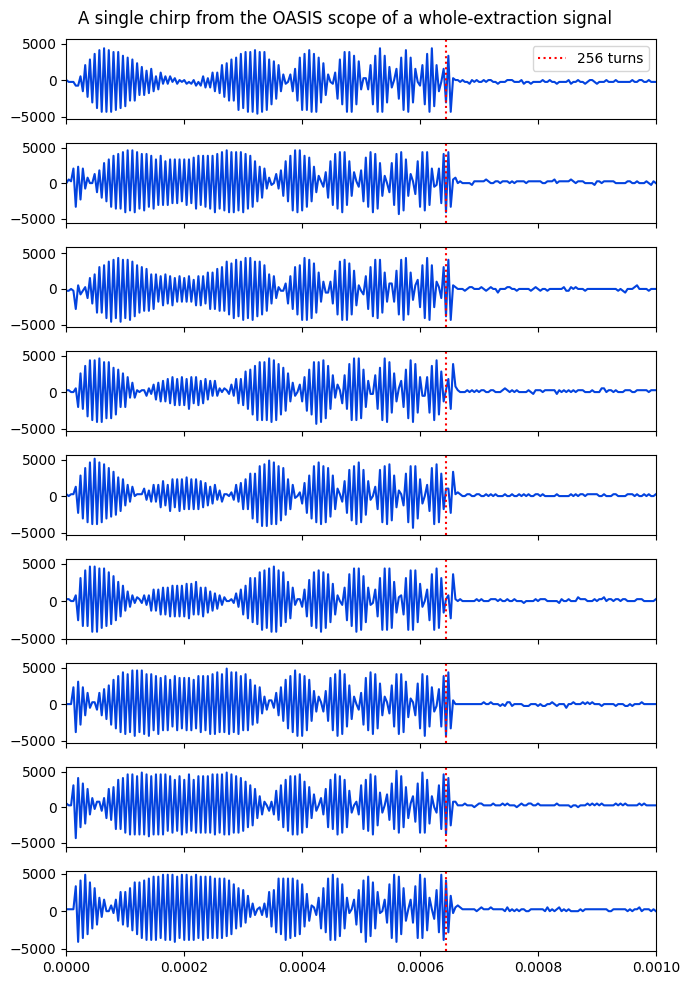

In [73]:
# Gain scan
dir = '../results/2022-11-23T15:08:29'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files[1:]]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files[1:]]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files[1:]]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files[1:]]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files[1:]]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files[1:]]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files[1:]]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files[1:]]

# scope_time_per_sample = 0.05 / len(scope0[0]['data']['time'])
# scope_sample_rate = 1/scope_time_per_sample

# cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
# cal_sample_rate = 1/cal_time_per_sample

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 1, figsize=(7, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    cal_time_per_sample = ((cal['timeArray'] - cal['timeArray'][0]) * 1e-6)[-1] / len(cal['timeArray'])
    cal_sample_rate = 1/cal_time_per_sample

    rep_rate = param/1000
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)


    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i].plot(scp_timeRebase, scp_data, 'xkcd:blue')

    ax[i].set_xlim(0, 1e-3)
    ax[i].axvline(1e-3/397 * 256, 0, 1, color='r', linestyle=':', label='256 turns')
    
ax[0].legend()

plt.suptitle("A single chirp from the OASIS scope of a whole-extraction signal")

In [79]:
### Ideal signal ###
# set start and stop freq
start = 397*1e3*0.3
stop = 397*1e3*0.35
dur = 1e-3/397 * 256

# Generate arrays
timearr, timestep = np.linspace(0, dur, int(10000), retstep=True)
amparr = chirpsig(timearr, start, timearr[-1], stop)
ideal_time_per_sample = timearr[-1] / len(timearr)
ideal_sample_rate = 1/ideal_time_per_sample


dir = '../results/2022-11-23T15:08:29'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files[1:]]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files[1:]]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files[1:]]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files[1:]]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files[1:]]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files[1:]]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files[1:]]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files[1:]]

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 1, figsize=(14, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])

    padtime = np.arange(dur, param*1e-3, timestep)
    padval = np.zeros(padtime.shape)

    # concat arrays
    fulltime = np.arange(0, param*1e-3+(timestep), timestep)
    fullamp = np.concatenate((amparr, padval))

    tileamp = np.tile(fullamp, 500//param)
    timetime = np.arange(0, fulltime[-1]*(500//param) + (500//param * timestep), timestep)

    ax[i].plot(timetime[:len(tileamp)], (tileamp*4500), 'xkcd:green')

    ax[i].plot(scp_timeRebase, scp_data, 'xkcd:blue')

    ax[i].set_xlim(0, 1e-2)

ax[i].set_xlabel("Time (s)")
plt.suptitle("Comparing ideal repeating chirp sequence to measured data")
plt.tight_layout(pad=0.8, w_pad=0.1, h_pad=0.4)

In [140]:
### Ideal signal ###
# set start and stop freq
start = 397*1e3*0.3
stop = 397*1e3*0.35
dur = 1e-3/397 * 256

# Generate arrays
timearr, timestep = np.linspace(0, dur, int(10000), retstep=True)
amparr = chirpsig(timearr, start, timearr[-1], stop)
ideal_time_per_sample = timearr[-1] / len(timearr)
ideal_sample_rate = 1/ideal_time_per_sample


dir = '../results/2022-11-23T15:08:29'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files[1:]]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files[1:]]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files[1:]]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files[1:]]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files[1:]]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files[1:]]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files[1:]]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files[1:]]

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 3, figsize=(14, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])

    padtime = np.arange(dur, param*1e-3, timestep)
    padval = np.zeros(padtime.shape)

    # concat arrays
    fulltime = np.arange(0, param*1e-3+(timestep), timestep)
    fullamp = np.concatenate((amparr, padval))

    tileamp = np.tile(fullamp, 500//param)
    timetime = np.arange(0, fulltime[-1]*(500//param) + (500//param * timestep), timestep)

    ax[i, 0].plot(timetime[:len(tileamp)], (tileamp*4500), 'xkcd:green')

    ax[i, 0].plot(scp_timeRebase, scp_data, 'xkcd:blue')

    ax[i, 0].set_xlim(0, 1e-2)

    ideal_fft = rfft(fullamp)
    ideal_fft_freq = rfftfreq(len(fullamp), d=timestep)

    scp_fft = rfft(scp_data)
    scp_fft_freq = rfftfreq(len(scp_data), d=scp_timeRebase[1]-scp_timeRebase[0])

    ax[i, 1].plot(scp_fft_freq, np.abs(scp_fft), 'xkcd:blue', label="Measured signal FFT")
    ax[i, 1].plot(ideal_fft_freq, np.abs(ideal_fft)*5000, 'xkcd:green', label="Ideal signal FFT")
    
    ax[i, 1].set_xlim(0, 2e5)
    #ax[i, 1].set_yscale('log')

    ax[i, 2].plot(scp_fft_freq, np.abs(scp_fft), 'xkcd:blue', label="Measured signal FFT")
    ax[i, 2].plot(ideal_fft_freq, np.abs(ideal_fft)*5000, 'xkcd:green', label="Ideal signal FFT")

    ax[i, 2].set_xlim(0, 2e3)
    ax[i, 2].set_yscale('log')
    ax[i, 2].axvline(1/(param*1e-3), color='xkcd:red', linestyle=":", label="Expected frequency")



fmt = lambda x, pos: '{:.0f}'.format(x*1e-3, pos)
ax[0, 1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

ax[0, 1].legend()
ax[i, 0].set_xlabel("Time (s)")
ax[i, 1].set_xlabel("Frequency (kHz)")
ax[i, 2].set_xlabel("Frequency (Hz)")
plt.suptitle("Comparing ideal repeating chirp sequence to measured data")
plt.tight_layout(pad=0.8, w_pad=0.1, h_pad=0.4)

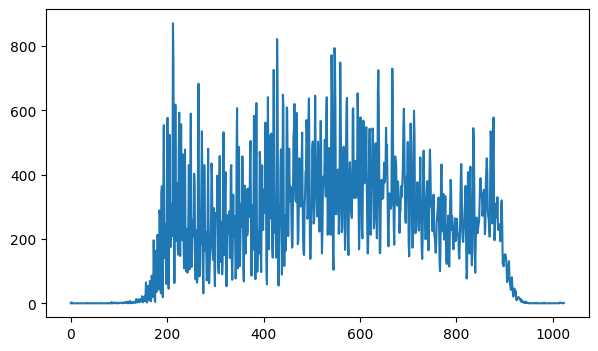

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(int1000[5]['countArray'])